In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

from data_preprocessing import process_resstock_data
from models import MLPModel, LinearRegressionModel
from pvalues import get_pvalues

# Load data

### Setpoint timeseries

In [2]:
# full_heating_timeseries, full_cooling_timeseries = generate_setpoint_timeseries(
#     cooling_start_date = "2018-06-01",
#     cooling_end_date = "2018-10-31",
#     combine = False
# )

In [3]:
# # Save heaitng and cooling timeseries to pickle
# with open('/Users/adrian/Documents/ICAI/TFG/Space-Conditioning-Electrification/data/consumption/full_heating_timeseries.pkl', 'wb') as f:
#     pickle.dump(full_heating_timeseries, f)
# with open('/Users/adrian/Documents/ICAI/TFG/Space-Conditioning-Electrification/data/consumption/full_cooling_timeseries.pkl', 'wb') as f:
#     pickle.dump(full_cooling_timeseries, f)

In [4]:
# Load full heating and cooling timeseries
with open('/Users/adrian/Documents/ICAI/TFG/Space-Conditioning-Electrification/data/consumption/full_heating_timeseries.pkl', 'rb') as f:
    full_heating_timeseries = pickle.load(f)
with open('/Users/adrian/Documents/ICAI/TFG/Space-Conditioning-Electrification/data/consumption/full_cooling_timeseries.pkl', 'rb') as f:
    full_cooling_timeseries = pickle.load(f)

### Weather data

In [5]:
weather_data = pd.read_csv("/Users/adrian/Documents/ICAI/TFG/Space-Conditioning-Electrification/data/consumption/G2500170_2018.csv")

In [6]:
weather_data.head()

,date_time,Dry Bulb Temperature [°C],Relative Humidity [%],Wind Speed [m/s],Wind Direction [Deg],Global Horizontal Radiation [W/m2],Direct Normal Radiation [W/m2],Diffuse Horizontal Radiation [W/m2]
0,2018-01-01 01:00:00,-17.2,47.00,7.2,310.0,0.0,0.0,0.0
1,2018-01-01 02:00:00,-17.8,46.83,6.7,300.0,0.0,0.0,0.0
2,2018-01-01 03:00:00,-18.9,55.19,2.1,260.0,0.0,0.0,0.0
3,2018-01-01 04:00:00,-18.9,51.97,4.1,280.0,0.0,0.0,0.0
4,2018-01-01 05:00:00,-19.4,54.51,3.6,280.0,0.0,0.0,0.0


### ResStock

In [7]:
resstock = pd.read_parquet("/Users/adrian/Documents/ICAI/TFG/Space-Conditioning-Electrification/data/consumption/MA_baseline_metadata_and_annual_results.parquet")

### Building timeseries

In [8]:
building_data = pd.read_parquet("/Users/adrian/Documents/ICAI/TFG/Space-Conditioning-Electrification/data/consumption/1000-0.parquet")

### Setpoint timeseries plot

In [9]:
heating_timeseries = full_heating_timeseries[1000]
cooling_timeseries = full_cooling_timeseries[1000]

heating_timeseries = pd.concat([heating_timeseries.loc["2018-01-01":"2018-05-31"], heating_timeseries.loc["2018-11-01":"2018-12-31"]])
cooling_timeseries = cooling_timeseries.loc["2018-06-01":"2018-10-31"]

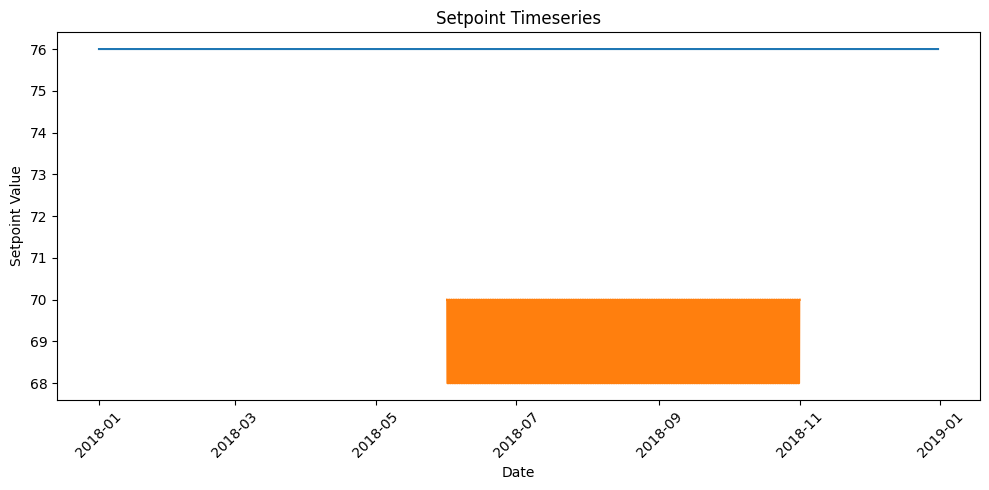

In [10]:
# Plot the timeseries
plt.figure(figsize=(10, 5))
plt.plot(heating_timeseries.index, heating_timeseries["setpoint"])
plt.plot(cooling_timeseries.index, cooling_timeseries["setpoint"])
plt.title("Setpoint Timeseries")
plt.xlabel("Date")
plt.ylabel("Setpoint Value")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# ResStock transform

In [11]:
columns = [
    "in.bedrooms",              # int
    "in.duct_leakage_and_insulation",    # Separate into leakage / insulation: X% / (Uniinsulated/R-n)
    "in.duct_location",         # Places of the house
    "in.geometry_floor_area",   # 1000-1499, ...
    "in.geometry_stories",      # int
    "in.geometry_wall_type",    # Materials
    "in.ground_thermal_conductivity",   # float
    "in.hvac_has_ducts",    # Yes / No
    "in.insulation_ceiling",    # R-n / Uninsulated
    "in.insulation_floor",      # R-n / Uninsulated
    "in.insulation_foundation_wall",    # Wall R-n, Exterior
    "in.insulation_roof",       # Finished / Unfinished, R-n
    "in.insulation_wall",       # Material, Uninsulated / R-n
    "in.occupants",         # int
    "in.orientation",       # North, Northwest...
    "in.roof_material",     # Material
    "in.sqft",              # int
    "in.windows"    # Single/Double/Triple, Low-E/Clear, Metal/Non-metal, Air/Exterior Clear Storm, (L/M-Gain)
    "in.window_areas",
    "in.vintage",
]

In [12]:
columns_processed = [
    "in.bedrooms_processed",              # int
    "in.duct_leakage_processed",
    "in.duct_insulation_processed",    # Separate into leakage / insulation: X% / (Uniinsulated/R-n)
    "in.duct_location_processed",         # Places of the house
    "in.geometry_floor_area_processed",   # 1000-1499, ...
    "in.geometry_stories_processed",      # int
    "in.geometry_wall_type_processed",    # Materials
    "in.ground_thermal_conductivity_processed",   # float
    "in.hvac_has_ducts_processed",    # Yes / No
    "in.insulation_ceiling_processed",    # R-n / Uninsulated
    "in.insulation_floor_processed",      # R-n / Uninsulated
    "in.insulation_foundation_wall_processed",    # Wall R-n, Exterior
    "in.insulation_roof_processed",       # Finished / Unfinished, R-n
    "in.insulation_wall_processed",       # Material, Uninsulated / R-n
    "in.occupants_processed",         # int
    "in.orientation_processed",       # North, Northwest...
    "in.roof_material_processed",     # Material
    "in.sqft_processed",              # int
    "in.windows_processed", # Single/Double/Triple, Low-E/Clear, Metal/Non-metal, Air/Exterior Clear Storm, (L/M-Gain)
    "in.window_areas_processed",
    "in.vintage_processed",
    
]

In [13]:
resstock_processed = process_resstock_data(resstock)

In [14]:
resstock_processed["in.vintage_processed"].value_counts()

in.vintage_processed
1930    3820
1970    1386
1950    1312
1980    1269
1960    1220
1990     895
2000     825
1940     614
2010     366
Name: count, dtype: int64

In [15]:
usable_resstock = resstock_processed[columns_processed]

In [16]:
usable_resstock.head()

,in.bedrooms_processed,in.duct_leakage_processed,in.duct_insulation_processed,in.duct_location_processed,in.geometry_floor_area_processed,in.geometry_stories_processed,in.geometry_wall_type_processed,in.ground_thermal_conductivity_processed,in.hvac_has_ducts_processed,in.insulation_ceiling_processed,...,in.insulation_foundation_wall_processed,in.insulation_roof_processed,in.insulation_wall_processed,in.occupants_processed,in.orientation_processed,in.roof_material_processed,in.sqft_processed,in.windows_processed,in.window_areas_processed,in.vintage_processed
bldg_id,,,,,,,,,,,,,,,,,,,,,
10,3,10,0,4,1749,1,1,1.4,1,5,...,1,0,0,6,1,3,1228,2,18,1950
122,1,0,0,0,874,5,1,1.4,0,0,...,1,6,0,1,5,0,623,2,18,1950
129,1,0,0,0,874,2,2,1.1,0,0,...,1,5,1,1,4,0,623,1,15,1970
150,2,0,0,0,1749,3,1,1.1,0,0,...,0,3,4,1,3,0,1138,2,15,2000
183,3,0,0,0,1749,1,1,1.4,0,1,...,1,0,0,2,3,1,1228,2,18,1930


In [17]:
building_resstock = np.array(usable_resstock.loc[1000])

In [18]:
building_resstock

array([3.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 2.499e+03, 1.000e+00,
       2.000e+00, 1.400e+00, 0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00,
       5.000e+00, 0.000e+00, 3.000e+00, 0.000e+00, 0.000e+00, 1.682e+03,
       2.000e+00, 1.500e+01, 1.930e+03])

# Transform data

In [19]:
def get_cols(building_data: pd.DataFrame, building_id: int) -> str:

    try:
        building = building_data.loc[building_id]
    except:
        raise ValueError("Building ID not found in the dataset")

    match building["in.heating_fuel"]:
        case  "Natural Gas":
            return "out.natural_gas.heating.energy_consumption"
        case "Electricity":
            return "out.electricity.heating.energy_consumption"
        case "Fuel Oil":
            return "out.fuel_oil.heating.energy_consumption"
        case "Propane":
            return "out.propane.heating.energy_consumption"
        case _:
            return "out.electricity.heating.energy_consumption"

In [20]:
weather_data.columns

Index(['date_time', 'Dry Bulb Temperature [°C]', 'Relative Humidity [%]',
       'Wind Speed [m/s]', 'Wind Direction [Deg]',
       'Global Horizontal Radiation [W/m2]', 'Direct Normal Radiation [W/m2]',
       'Diffuse Horizontal Radiation [W/m2]'],
      dtype='object')

In [21]:
weather_data.head()

,date_time,Dry Bulb Temperature [°C],Relative Humidity [%],Wind Speed [m/s],Wind Direction [Deg],Global Horizontal Radiation [W/m2],Direct Normal Radiation [W/m2],Diffuse Horizontal Radiation [W/m2]
0,2018-01-01 01:00:00,-17.2,47.00,7.2,310.0,0.0,0.0,0.0
1,2018-01-01 02:00:00,-17.8,46.83,6.7,300.0,0.0,0.0,0.0
2,2018-01-01 03:00:00,-18.9,55.19,2.1,260.0,0.0,0.0,0.0
3,2018-01-01 04:00:00,-18.9,51.97,4.1,280.0,0.0,0.0,0.0
4,2018-01-01 05:00:00,-19.4,54.51,3.6,280.0,0.0,0.0,0.0


In [22]:
# Change date time column name to timestamp
weather_data.rename(columns={'date_time': "timestamp"}, inplace=True)
weather_data.set_index('timestamp', inplace=True)
weather_data.index = pd.to_datetime(weather_data.index)

# Delete all columns except dry bulb temperature
weather_data = weather_data[["Dry Bulb Temperature [°C]", "Direct Normal Radiation [W/m2]"]]
weather_data.rename(columns={"Dry Bulb Temperature [°C]": "temperature"}, inplace=True)

# Create an entry for 2018-01-01 00:00:00
new_row = pd.DataFrame({'temperature': weather_data.iloc[0]['temperature']}, index=[pd.to_datetime('2018-01-01 00:00:00')])
weather_data = pd.concat([new_row, weather_data])

# Remove last 19 rows
weather_data = weather_data[:-24]

In [23]:
weather_data.bfill(inplace=True)
weather_data.ffill(inplace=True)

In [24]:
building_id = 1000

In [25]:
col_to_use = get_cols(resstock, building_id)
consumption_timeseries = building_data[["timestamp", col_to_use]]

# Resample to hourly data
consumption_timeseries["timestamp"] = pd.to_datetime(consumption_timeseries["timestamp"])
consumption_timeseries.set_index("timestamp", inplace=True)
consumption_timeseries = consumption_timeseries.resample("H").mean()
consumption_timeseries = consumption_timeseries[col_to_use]

consumption_timeseries = consumption_timeseries[:-24]

# Turn into dataframe
consumption_timeseries = pd.DataFrame(consumption_timeseries)
consumption_timeseries.rename(columns={col_to_use: "consumption"}, inplace=True)

/var/folders/bw/4qyc6pj92bdb1bv22yhll2zw0000gn/T/ipykernel_9208/3969840236.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  consumption_timeseries["timestamp"] = pd.to_datetime(consumption_timeseries["timestamp"])
/var/folders/bw/4qyc6pj92bdb1bv22yhll2zw0000gn/T/ipykernel_9208/3969840236.py:7: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  consumption_timeseries = consumption_timeseries.resample("H").mean()


In [26]:
exog_variables = pd.merge(
    consumption_timeseries,
    weather_data,
    left_index=True,
    right_index=True,
)

In [27]:
def celsius_to_fahrenheit(celsius):
    return (celsius * 9/5) + 32

In [28]:
# Change temperature column to fahrenheit
exog_variables["temperature"] = exog_variables["temperature"].apply(celsius_to_fahrenheit)

In [29]:
heating_exog = exog_variables.loc[heating_timeseries.index]
cooling_exog = exog_variables.loc[cooling_timeseries.index]

In [30]:
cooling_exog["temperature"].value_counts()

temperature
66.920    109
69.080    105
69.980     99
68.000     97
71.960     96
         ... 
84.380      1
73.886      1
69.764      1
70.970      1
52.430      1
Name: count, Length: 397, dtype: int64

# Data Plot

In [31]:
train_size = 0.8
heating_endog_train = heating_timeseries[:int(train_size * len(heating_timeseries))]
heating_endog_test = heating_timeseries[int(train_size * len(heating_timeseries)):]

heating_exog_train = heating_exog[:int(train_size * len(heating_exog))]
heating_exog_test = heating_exog[int(train_size * len(heating_exog)):]

cooling_endog_train = cooling_timeseries[:int(train_size * len(cooling_timeseries))]
cooling_endog_test = cooling_timeseries[int(train_size * len(cooling_timeseries)):]

cooling_exog_train = cooling_exog[:int(train_size * len(cooling_exog))]
cooling_exog_test = cooling_exog[int(train_size * len(cooling_exog)):]

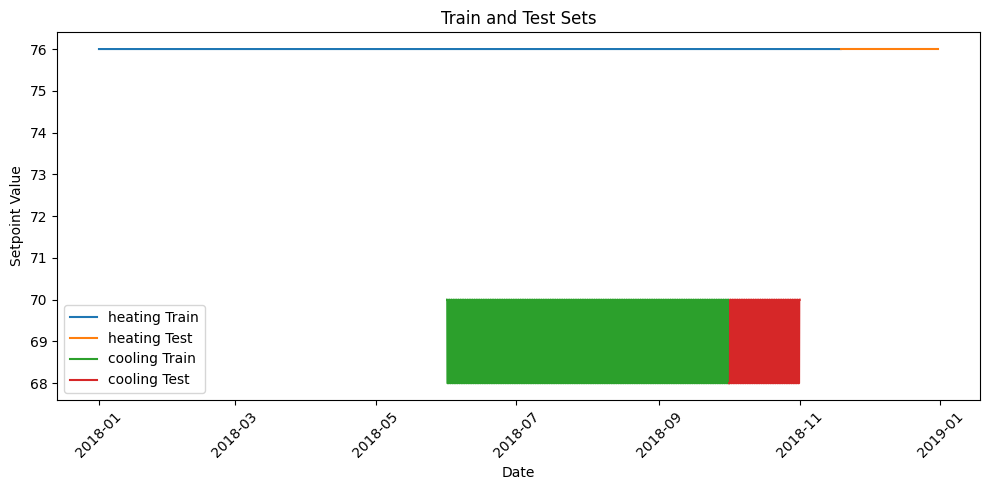

In [32]:
# Plot the training and test sets
plt.figure(figsize=(10, 5))
plt.plot(heating_endog_train.index, heating_endog_train["setpoint"], label="heating Train")
plt.plot(heating_endog_test.index, heating_endog_test["setpoint"], label="heating Test")
plt.plot(cooling_endog_train.index, cooling_endog_train["setpoint"], label="cooling Train")
plt.plot(cooling_endog_test.index, cooling_endog_test["setpoint"], label="cooling Test")
plt.title("Train and Test Sets")
plt.xlabel("Date")
plt.ylabel("Setpoint Value")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Datasets and Dataloaders

In [33]:
heating_train_timeseries = pd.merge(heating_endog_train, heating_exog_train, left_index=True, right_index=True)
heating_test_timeseries = pd.merge(heating_endog_test, heating_exog_test, left_index=True, right_index=True)

cooling_train_timeseries = pd.merge(cooling_endog_train, cooling_exog_train, left_index=True, right_index=True)
cooling_test_timeseries = pd.merge(cooling_endog_test, cooling_exog_test, left_index=True, right_index=True)

In [34]:
heating_train_timeseries.head()

,setpoint,consumption,temperature,Direct Normal Radiation [W/m2]
timestamp,,,,
2018-01-01 00:00:00,76.0,4.691970,1.04,0.0
2018-01-01 01:00:00,76.0,5.008804,1.04,0.0
2018-01-01 02:00:00,76.0,4.799112,-0.04,0.0
2018-01-01 03:00:00,76.0,4.963452,-2.02,0.0
2018-01-01 04:00:00,76.0,5.047929,-2.02,0.0


In [35]:
def create_lr_sequences(data, sequence_length, building_resstock):
    sequences = []
    labels = []

    for i in range(len(data) - sequence_length - 1):
        sequence = np.array(data.iloc[i:i+sequence_length])
        label = data.iloc[i+sequence_length].iloc[0]
        sequences.append(sequence)
        labels.append(label)
    return np.array(sequences), labels

In [36]:
sequence_length = 12
batch_size = 64

heating_train_sequences, heating_train_labels = create_lr_sequences(heating_train_timeseries, sequence_length, building_resstock)
heating_test_sequences, heating_test_labels = create_lr_sequences(heating_test_timeseries, sequence_length, building_resstock)

cooling_train_sequences, cooling_train_labels = create_lr_sequences(cooling_train_timeseries, sequence_length, building_resstock)
cooling_test_sequences, cooling_test_labels = create_lr_sequences(cooling_test_timeseries, sequence_length, building_resstock)

In [37]:
heating_train_sequences = heating_train_sequences.reshape(heating_train_sequences.shape[0], -1)
heating_test_sequences = heating_test_sequences.reshape(heating_test_sequences.shape[0], -1)

cooling_train_sequences = cooling_train_sequences.reshape(cooling_train_sequences.shape[0], -1)
cooling_test_sequences = cooling_test_sequences.reshape(cooling_test_sequences.shape[0], -1)

In [38]:
building_resstock_repeated_heating_train = np.tile(building_resstock, (heating_train_sequences.shape[0], 1))
building_resstock_repeated_heating_test = np.tile(building_resstock, (heating_test_sequences.shape[0], 1))

building_resstock_repeated_cooling_train = np.tile(building_resstock, (cooling_train_sequences.shape[0], 1))
building_resstock_repeated_cooling_test = np.tile(building_resstock, (cooling_test_sequences.shape[0], 1))

In [39]:
heating_train_sequences = np.concatenate((heating_train_sequences, building_resstock_repeated_heating_train), axis=1)
heating_test_sequences = np.concatenate((heating_test_sequences, building_resstock_repeated_heating_test), axis=1)

cooling_train_sequences = np.concatenate((cooling_train_sequences, building_resstock_repeated_cooling_train), axis=1)
cooling_test_sequences = np.concatenate((cooling_test_sequences, building_resstock_repeated_cooling_test), axis=1)

In [40]:
class TimeSeriesDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = sequences
        self.labels = labels
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        return torch.tensor(self.sequences[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.float32)


In [41]:
heating_train_dataset = TimeSeriesDataset(heating_train_sequences, heating_train_labels)
heating_test_dataset = TimeSeriesDataset(heating_test_sequences, heating_test_labels)
heating_train_loader = DataLoader(heating_train_dataset, batch_size=batch_size, shuffle=True)
heating_test_loader = DataLoader(heating_test_dataset, batch_size=batch_size, shuffle=False)

cooling_train_dataset = TimeSeriesDataset(cooling_train_sequences, cooling_train_labels)
cooling_test_dataset = TimeSeriesDataset(cooling_test_sequences, cooling_test_labels)
cooling_train_loader = DataLoader(cooling_train_dataset, batch_size=batch_size, shuffle=True)
cooling_test_loader = DataLoader(cooling_test_dataset, batch_size=batch_size, shuffle=False)

# Train and evaluate fns

In [42]:
# Training function
def train(model, train_loader, criterion, optimizer, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for sequences, labels in train_loader:
            # Zero gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(sequences)
            loss = criterion(outputs, labels)  # Unsqueeze labels to match output dim
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}')

In [43]:
# Predict
def evaluate(model, test_loader):
    model.eval()
    predictions = []
    actuals = []
    with torch.no_grad():
        for sequences, labels in test_loader:
            outputs = model(sequences)
            predictions.append(outputs.numpy())
            actuals.append(labels.numpy())
    return np.concatenate(predictions), np.concatenate(actuals)

In [44]:
len(heating_train_dataset[0][0])

69

# MLP

In [45]:
input_size = 69
hidden_size_1 = 64
hidden_size_2 = 32
output_size = 1

In [46]:
heating_model = MLPModel(
    input_size, 
    hidden_size_1=hidden_size_1, 
    hidden_size_2=hidden_size_2,
    output_size=output_size)

In [47]:
# Loss and optimizer
heating_criterion = nn.MSELoss()
heating_optimizer = optim.Adam(heating_model.parameters(), lr=0.0001)

## Heating

In [48]:
num_epochs = 100
train(heating_model, heating_train_loader, heating_criterion, heating_optimizer, num_epochs)

/Users/adrian/Documents/ICAI/TFG/Space-Conditioning-Electrification/.env/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/adrian/Documents/ICAI/TFG/Space-Conditioning-Electrification/.env/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/100, Loss: 3888.8142
Epoch 2/100, Loss: 380.3283
Epoch 3/100, Loss: 53.1345
Epoch 4/100, Loss: 11.0784
Epoch 5/100, Loss: 6.5604
Epoch 6/100, Loss: 5.0145
Epoch 7/100, Loss: 4.1072
Epoch 8/100, Loss: 3.5672
Epoch 9/100, Loss: 3.2449
Epoch 10/100, Loss: 2.9977
Epoch 11/100, Loss: 2.7616
Epoch 12/100, Loss: 2.5536
Epoch 13/100, Loss: 2.3607
Epoch 14/100, Loss: 2.1757
Epoch 15/100, Loss: 1.9715
Epoch 16/100, Loss: 1.8027
Epoch 17/100, Loss: 1.6786
Epoch 18/100, Loss: 1.5325
Epoch 19/100, Loss: 1.4108
Epoch 20/100, Loss: 1.2867
Epoch 21/100, Loss: 1.1768
Epoch 22/100, Loss: 1.0807
Epoch 23/100, Loss: 0.9763
Epoch 24/100, Loss: 0.8888
Epoch 25/100, Loss: 0.8187
Epoch 26/100, Loss: 0.7213
Epoch 27/100, Loss: 0.6416
Epoch 28/100, Loss: 0.5891
Epoch 29/100, Loss: 0.5051
Epoch 30/100, Loss: 0.4556
Epoch 31/100, Loss: 0.4128
Epoch 32/100, Loss: 0.3692
Epoch 33/100, Loss: 0.3371
Epoch 34/100, Loss: 0.3059
Epoch 35/100, Loss: 0.2927
Epoch 36/100, Loss: 0.2674
Epoch 37/100, Loss: 0.2468
Epo

In [49]:
# Predict
heating_predictions, heating_actuals = evaluate(heating_model, heating_test_loader)

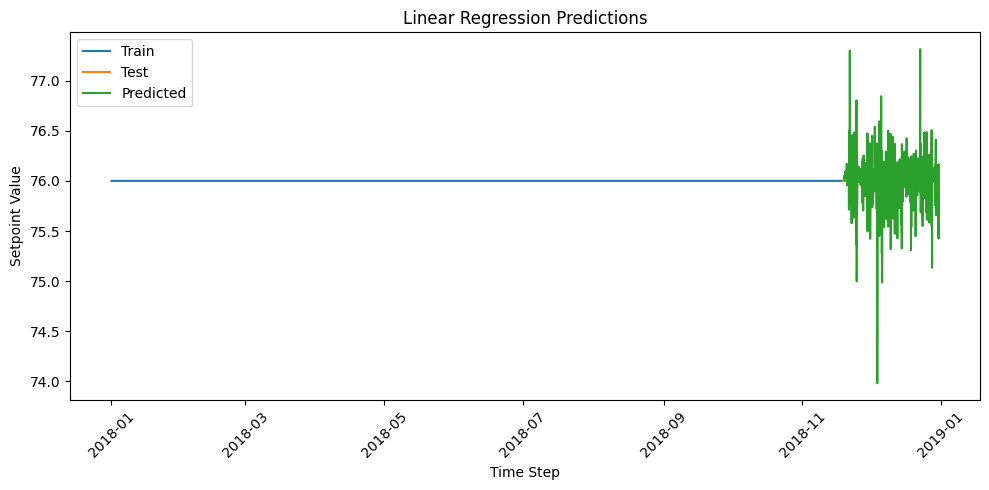

In [50]:
# Plot train, test and predictions
plt.figure(figsize=(10, 5))
plt.plot(heating_train_timeseries.index, heating_train_timeseries["setpoint"], label="Train")
plt.plot(heating_test_timeseries.index, heating_test_timeseries["setpoint"], label="Test")
plt.plot(heating_test_timeseries.index[13:], heating_predictions, label="Predicted")
plt.title("Linear Regression Predictions")
plt.xlabel("Time Step")
plt.ylabel("Setpoint Value")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Cooling

In [51]:
input_size = 69
hidden_size_1 = 64
hidden_size_2 = 32
output_size = 1

In [52]:
cooling_model = MLPModel(
    input_size, 
    hidden_size_1=hidden_size_1, 
    hidden_size_2=hidden_size_2,
    output_size=output_size)

In [53]:
# Loss and optimizer
cooling_criterion = nn.MSELoss()
cooling_optimizer = optim.Adam(cooling_model.parameters(), lr=0.0001)

In [54]:
num_epochs = 100
train(cooling_model, cooling_train_loader, cooling_criterion, cooling_optimizer, num_epochs)

/Users/adrian/Documents/ICAI/TFG/Space-Conditioning-Electrification/.env/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([44])) that is different to the input size (torch.Size([44, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/100, Loss: 5404.6406
Epoch 2/100, Loss: 319.5056
Epoch 3/100, Loss: 102.6019
Epoch 4/100, Loss: 47.0626
Epoch 5/100, Loss: 30.7429
Epoch 6/100, Loss: 21.7886
Epoch 7/100, Loss: 16.0113
Epoch 8/100, Loss: 12.7997
Epoch 9/100, Loss: 10.6575
Epoch 10/100, Loss: 9.2280
Epoch 11/100, Loss: 8.0496
Epoch 12/100, Loss: 7.2609
Epoch 13/100, Loss: 6.6618
Epoch 14/100, Loss: 6.1260
Epoch 15/100, Loss: 5.6895
Epoch 16/100, Loss: 5.3931
Epoch 17/100, Loss: 5.0636
Epoch 18/100, Loss: 4.8016
Epoch 19/100, Loss: 4.5871
Epoch 20/100, Loss: 4.3820
Epoch 21/100, Loss: 4.2132
Epoch 22/100, Loss: 4.0347
Epoch 23/100, Loss: 3.8811
Epoch 24/100, Loss: 3.7388
Epoch 25/100, Loss: 3.5946
Epoch 26/100, Loss: 3.4933
Epoch 27/100, Loss: 3.3253
Epoch 28/100, Loss: 3.2016
Epoch 29/100, Loss: 3.1595
Epoch 30/100, Loss: 3.0360
Epoch 31/100, Loss: 2.9292
Epoch 32/100, Loss: 2.8528
Epoch 33/100, Loss: 2.7829
Epoch 34/100, Loss: 2.6979
Epoch 35/100, Loss: 2.6388
Epoch 36/100, Loss: 2.5606
Epoch 37/100, Loss: 2.49

In [55]:
# Predict
cooling_predictions, cooling_actuals = evaluate(cooling_model, cooling_test_loader)

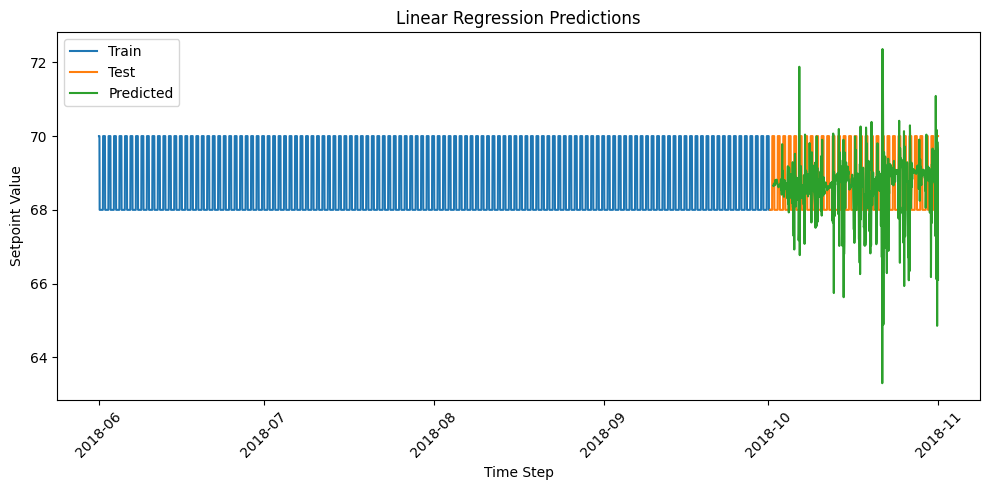

In [56]:
# Plot train, test and predictions
plt.figure(figsize=(10, 5))
plt.plot(cooling_train_timeseries.index, cooling_train_timeseries["setpoint"], label="Train")
plt.plot(cooling_test_timeseries.index, cooling_test_timeseries["setpoint"], label="Test")
plt.plot(cooling_test_timeseries.index[13:], cooling_predictions, label="Predicted")
plt.title("Linear Regression Predictions")
plt.xlabel("Time Step")
plt.ylabel("Setpoint Value")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Akaike

In [57]:
def compute_aic(y_true, y_pred, num_params):
    n = y_true.numel()
    residuals = y_true - y_pred
    rss = torch.sum(residuals ** 2).item()
    sigma2 = rss / n
    log_likelihood = -n/2 * (np.log(2 * np.pi * sigma2) + 1)
    aic = 2 * num_params - 2 * log_likelihood
    return aic

In [58]:
heating_num_params = sum(p.numel() for p in heating_model.parameters() if p.requires_grad)

In [59]:
heating_aic = compute_aic(
    torch.tensor(heating_actuals), 
    torch.tensor(heating_predictions), 
    heating_num_params
)

In [60]:
heating_aic

np.float64(19811.866910005945)

In [61]:
cooling_num_params = sum(p.numel() for p in cooling_model.parameters() if p.requires_grad)
cooling_aic = compute_aic(
    torch.tensor(cooling_actuals), 
    torch.tensor(cooling_predictions), 
    cooling_num_params
)
cooling_aic

np.float64(20313.57816386445)

# ARIMA

## Add lag to variables

In [62]:
import warnings
warnings.filterwarnings("ignore")

# Add lag of 1 to consumption, and create new temperature column with lag 1
heating_exog_train["temperature_lag_1"] = heating_exog_train["temperature"].shift(1)
heating_exog_train["consumption_lag_1"] = heating_exog_train["consumption"].shift(1)
heating_exog_train.drop(columns=["consumption"], inplace=True)
heating_exog_train.bfill(inplace=True)

heating_exog_test["temperature_lag_1"] = heating_exog_test["temperature"].shift(1)
heating_exog_test["consumption_lag_1"] = heating_exog_test["consumption"].shift(1)
heating_exog_test.drop(columns=["consumption"], inplace=True)
heating_exog_test.bfill(inplace=True)

cooling_exog_train["temperature_lag_1"] = cooling_exog_train["temperature"].shift(1)
cooling_exog_train["consumption_lag_1"] = cooling_exog_train["consumption"].shift(1)
cooling_exog_train.drop(columns=["consumption"], inplace=True)
cooling_exog_train.bfill(inplace=True)

cooling_exog_test["temperature_lag_1"] = cooling_exog_test["temperature"].shift(1)
cooling_exog_test["consumption_lag_1"] = cooling_exog_test["consumption"].shift(1)
cooling_exog_test.drop(columns=["consumption"], inplace=True)
cooling_exog_test.bfill(inplace=True)

In [63]:
heating_exog_train.head()

,temperature,Direct Normal Radiation [W/m2],temperature_lag_1,consumption_lag_1
timestamp,,,,
2018-01-01 00:00:00,1.04,0.0,1.04,4.691970
2018-01-01 01:00:00,1.04,0.0,1.04,4.691970
2018-01-01 02:00:00,-0.04,0.0,1.04,5.008804
2018-01-01 03:00:00,-2.02,0.0,-0.04,4.799112
2018-01-01 04:00:00,-2.02,0.0,-2.02,4.963452


## Heating

In [64]:
# Make sure heating_endog_train and heating_exog_train have hourly frequency
heating_endog_train = heating_endog_train.asfreq('h')
heating_exog_train = heating_exog_train.asfreq('h')

heating_endog_train.ffill(inplace=True)
heating_exog_train.ffill(inplace=True)
heating_endog_train.bfill(inplace=True)
heating_exog_train.bfill(inplace=True)

In [65]:
heating_arima_model = ARIMA(
    endog=heating_endog_train,
    exog=heating_exog_train,
    order=(0, 0, 0),
    freq="h",
)

In [66]:
heating_arima_model_fit = heating_arima_model.fit()

In [67]:
print(heating_arima_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:               setpoint   No. Observations:                 7724
Model:                          ARIMA   Log Likelihood               81827.955
Date:                Wed, 04 Jun 2025   AIC                        -163643.910
Time:                        11:41:28   BIC                        -163602.198
Sample:                    01-01-2018   HQIC                       -163629.607
                         - 11-18-2018                                         
Covariance Type:                  opg                                         
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                             76.0000   8.06e-23   9.42e+23      0.000      76.000      76.000
temperature                    -9.034e-15   4.94e-21  -1.83e+06      0.

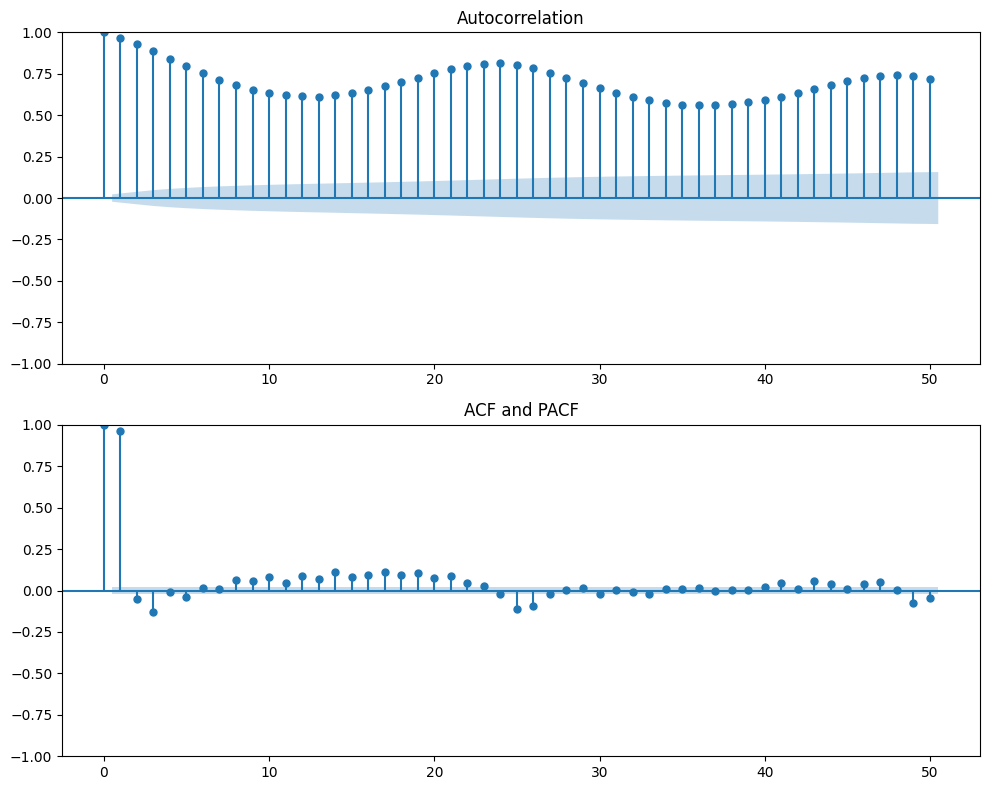

In [68]:
# Plot ACF and PACF

fig, ax = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(heating_arima_model_fit.resid, lags=50, ax=ax[0])
plot_pacf(heating_arima_model_fit.resid, lags=50, ax=ax[1])
plt.title("ACF and PACF")
plt.tight_layout()
plt.show()

In [69]:
# Predict
predictions = heating_arima_model_fit.get_forecast(steps=len(heating_endog_test), exog=heating_exog_test)
predicted_mean = predictions.predicted_mean
predicted_conf_int = predictions.conf_int()
lower_limits = predicted_conf_int.iloc[:, 0]
upper_limits = predicted_conf_int.iloc[:, 1]
predicted_mean = pd.Series(predicted_mean, index=heating_endog_test.index)

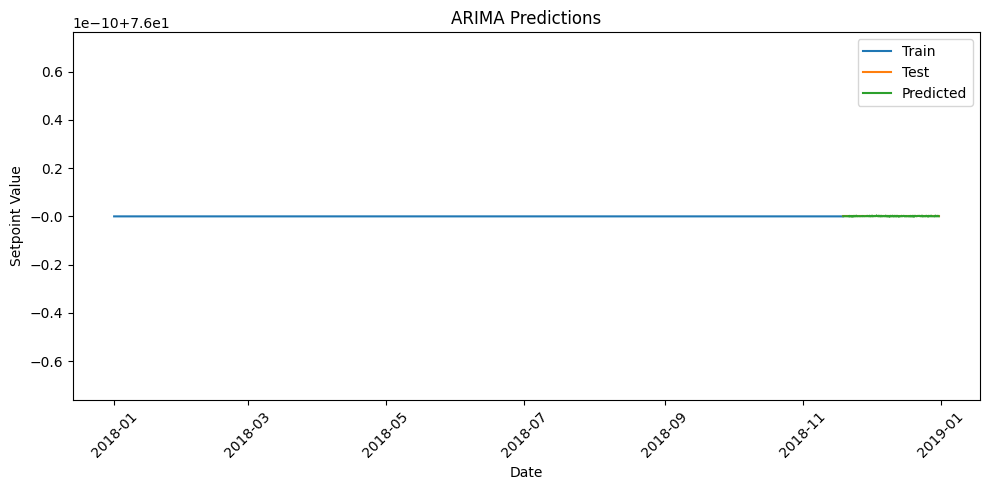

In [70]:
# Plot predictions
plt.figure(figsize=(10, 5))
plt.plot(heating_endog_train.index, heating_endog_train["setpoint"], label="Train")
plt.plot(heating_endog_test.index, heating_endog_test["setpoint"], label="Test")
plt.plot(predicted_mean.index, predicted_mean, label="Predicted")
plt.title("ARIMA Predictions")
plt.xlabel("Date")
plt.ylabel("Setpoint Value")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [71]:
heating_arima_model_fit.params

const                             7.600000e+01
temperature                      -9.034440e-15
Direct Normal Radiation [W/m2]    1.979753e-16
temperature_lag_1                 1.043610e-14
consumption_lag_1                -6.328271e-14
sigma2                            1.000000e-10
dtype: float64

## Cooling

In [72]:
# Make sure heating_endog_train and heating_exog_train have hourly frequency
cooling_endog_train = cooling_endog_train.asfreq('h')
cooling_exog_train = cooling_exog_train.asfreq('h')

cooling_endog_train.ffill(inplace=True)
cooling_exog_train.ffill(inplace=True)
cooling_endog_train.bfill(inplace=True)
cooling_exog_train.bfill(inplace=True)

In [73]:
cooling_arima_model = ARIMA(
    endog=cooling_endog_train,
    exog=cooling_exog_train,
    order=(1, 0, 0),
    seasonal_order=(1, 0, 0, 24),
    freq="h",
)

In [74]:
cooling_arima_model_fit = cooling_arima_model.fit()

In [75]:
print(cooling_arima_model_fit.summary())

                                    SARIMAX Results                                     
Dep. Variable:                         setpoint   No. Observations:                 2937
Model:             ARIMA(1, 0, 0)x(1, 0, 0, 24)   Log Likelihood                8405.049
Date:                          Wed, 04 Jun 2025   AIC                         -16794.097
Time:                                  11:41:38   BIC                         -16746.216
Sample:                              06-01-2018   HQIC                        -16776.856
                                   - 10-01-2018                                         
Covariance Type:                            opg                                         
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                             69.5000      2.308     30.113      0.000      64.976    

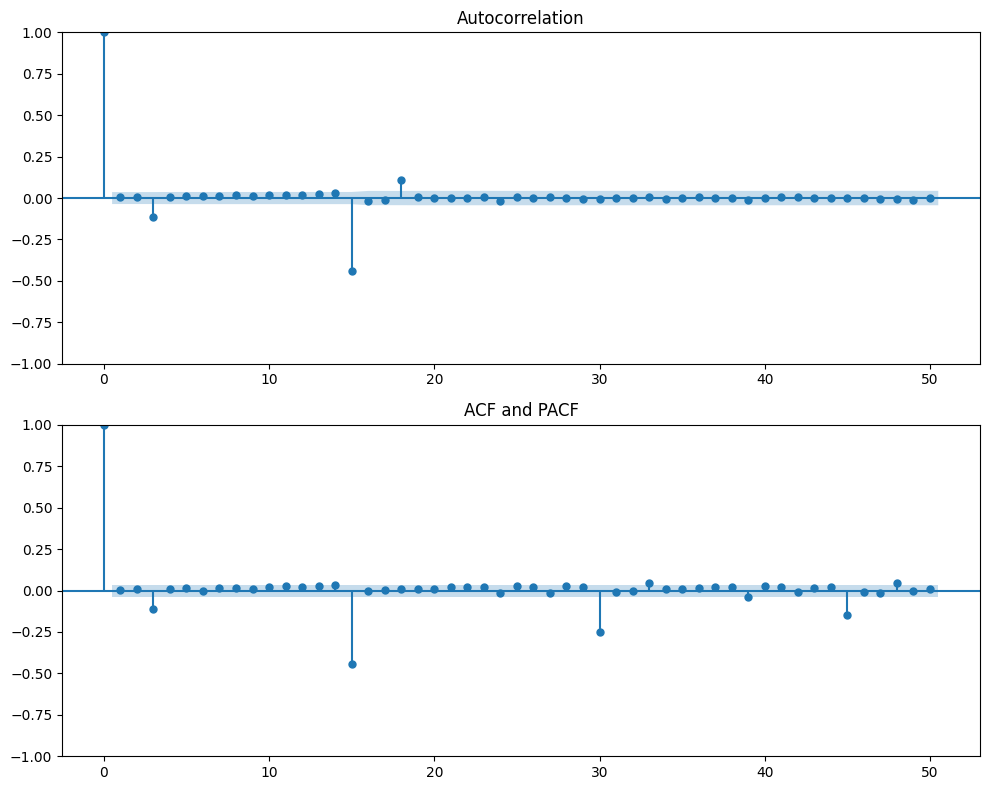

In [76]:
# Plot ACF and PACF

fig, ax = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(cooling_arima_model_fit.resid, lags=50, ax=ax[0])
plot_pacf(cooling_arima_model_fit.resid, lags=50, ax=ax[1])
plt.title("ACF and PACF")
plt.tight_layout()
plt.show()

In [77]:
# Predict
predictions = cooling_arima_model_fit.get_forecast(steps=len(cooling_endog_test), exog=cooling_exog_test)
predicted_mean = predictions.predicted_mean
predicted_conf_int = predictions.conf_int()
lower_limits = predicted_conf_int.iloc[:, 0]
upper_limits = predicted_conf_int.iloc[:, 1]
predicted_mean = pd.Series(predicted_mean, index=cooling_endog_test.index)

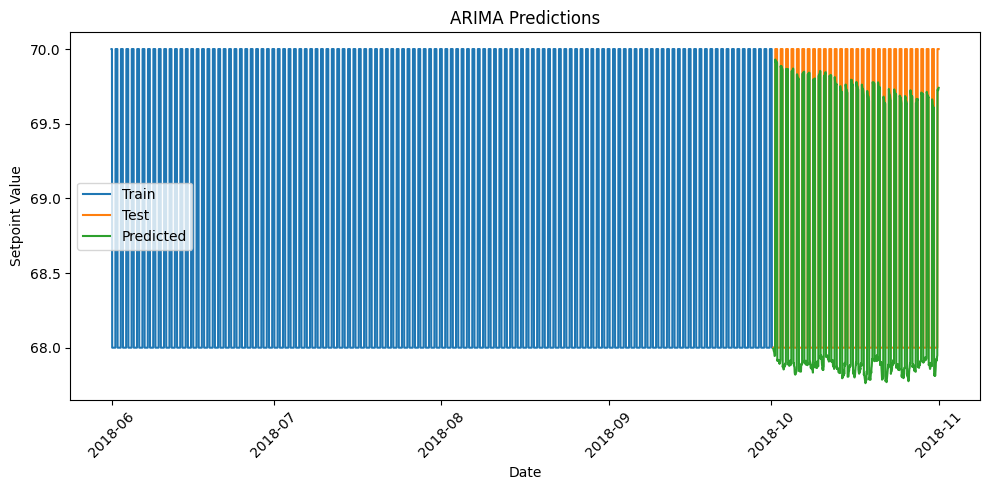

In [78]:
# Plot predictions
plt.figure(figsize=(10, 5))
plt.plot(cooling_endog_train.index, cooling_endog_train["setpoint"], label="Train")
plt.plot(cooling_endog_test.index, cooling_endog_test["setpoint"], label="Test")
plt.plot(predicted_mean.index, predicted_mean, label="Predicted")
plt.title("ARIMA Predictions")
plt.xlabel("Date")
plt.ylabel("Setpoint Value")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [79]:
# Print arima parameters
print(cooling_arima_model_fit.params)

const                             69.500000
temperature                        0.002301
Direct Normal Radiation [W/m2]    -0.000072
temperature_lag_1                 -0.002414
consumption_lag_1                 -0.125335
ar.L1                              0.979393
ar.S.L24                           0.996084
sigma2                             0.000199
dtype: float64


# Linear Regression

## Heating

In [80]:
heating_train = pd.merge(heating_endog_train, heating_exog_train, left_index=True, right_index=True)
heating_test = pd.merge(heating_endog_test, heating_exog_test, left_index=True, right_index=True)

In [81]:
# Set heating labels to the setpoint column
heating_train_labels = heating_train["setpoint"].values
heating_test_labels = heating_test["setpoint"].values

In [82]:
# Shift setpoint so that each column has the value of the previous hour
heating_train["setpoint"] = heating_train["setpoint"].shift(1)
heating_test["setpoint"] = heating_test["setpoint"].shift(1)

heating_train.ffill(inplace=True)
heating_test.ffill(inplace=True)
heating_train.bfill(inplace=True)
heating_test.bfill(inplace=True)

In [83]:
class LinearRegressionDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return torch.tensor(self.data[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.float32)
    
    def convert_to_numpy(self):
        return self.data

In [84]:
heating_lr_dataset_train = LinearRegressionDataset(heating_train.values, heating_train_labels)
heating_lr_dataset_test = LinearRegressionDataset(heating_test.values, heating_test_labels)

In [85]:
heating_lr_dataloader_train = DataLoader(heating_lr_dataset_train, batch_size=batch_size, shuffle=True)
heating_lr_dataloader_test = DataLoader(heating_lr_dataset_test, batch_size=batch_size, shuffle=False)

In [86]:
lr_heating_model = LinearRegressionModel(input_size=heating_train.shape[1], output_size=1, bias=False)

In [87]:
# Loss and optimizer
heating_lr_criterion = nn.MSELoss()
heating_lr_optimizer = optim.Adam(lr_heating_model.parameters(), lr=0.0001)

In [88]:
num_epochs = 300
train(lr_heating_model, heating_lr_dataloader_train, heating_lr_criterion, heating_lr_optimizer, num_epochs)

Epoch 1/300, Loss: 9364.1282
Epoch 2/300, Loss: 8833.8022
Epoch 3/300, Loss: 8315.4476
Epoch 4/300, Loss: 7832.2785
Epoch 5/300, Loss: 7367.1433
Epoch 6/300, Loss: 6915.1403
Epoch 7/300, Loss: 6492.4174
Epoch 8/300, Loss: 6085.7010
Epoch 9/300, Loss: 5700.2036
Epoch 10/300, Loss: 5335.2069
Epoch 11/300, Loss: 4984.2408
Epoch 12/300, Loss: 4651.0885
Epoch 13/300, Loss: 4337.7809
Epoch 14/300, Loss: 4040.9872
Epoch 15/300, Loss: 3755.2034
Epoch 16/300, Loss: 3487.5537
Epoch 17/300, Loss: 3233.0960
Epoch 18/300, Loss: 2993.5322
Epoch 19/300, Loss: 2767.4909
Epoch 20/300, Loss: 2553.7027
Epoch 21/300, Loss: 2352.3984
Epoch 22/300, Loss: 2164.6796
Epoch 23/300, Loss: 1987.0182
Epoch 24/300, Loss: 1821.6242
Epoch 25/300, Loss: 1666.3093
Epoch 26/300, Loss: 1521.2130
Epoch 27/300, Loss: 1386.5491
Epoch 28/300, Loss: 1260.5700
Epoch 29/300, Loss: 1145.0761
Epoch 30/300, Loss: 1037.1408
Epoch 31/300, Loss: 937.6376
Epoch 32/300, Loss: 846.3936
Epoch 33/300, Loss: 762.5911
Epoch 34/300, Loss: 68

In [89]:
# predict
heating_lr_predictions, heating_lr_actuals = evaluate(lr_heating_model, heating_lr_dataloader_test)

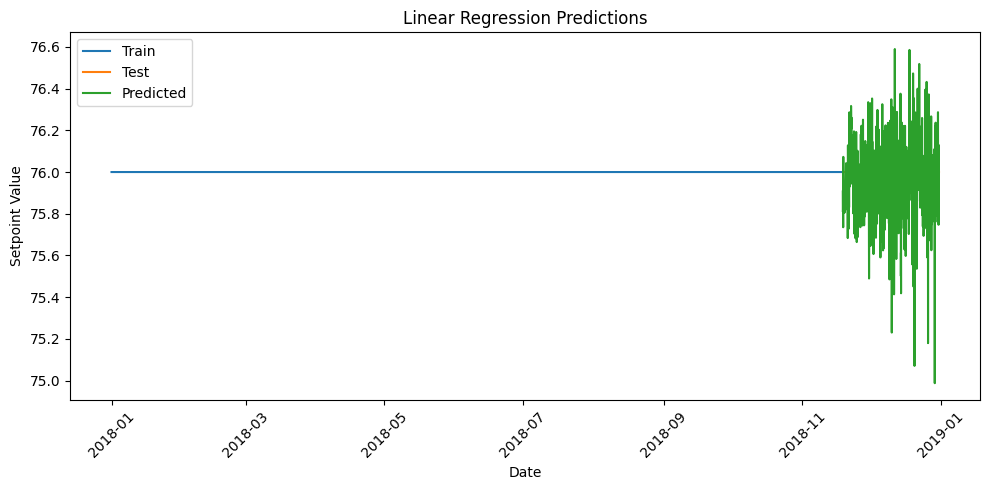

In [90]:
# plot predictions
plt.figure(figsize=(10, 5))
plt.plot(heating_train.index, heating_train["setpoint"], label="Train")
plt.plot(heating_test.index, heating_test["setpoint"], label="Test")
plt.plot(heating_test.index, heating_lr_predictions, label="Predicted")
plt.title("Linear Regression Predictions")
plt.xlabel("Date")
plt.ylabel("Setpoint Value")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Cooling

In [91]:
cooling_train = pd.merge(cooling_endog_train, cooling_exog_train, left_index=True, right_index=True)
cooling_test = pd.merge(cooling_endog_test, cooling_exog_test, left_index=True, right_index=True)

In [92]:
cooling_train_labels = cooling_train["setpoint"].values
cooling_test_labels = cooling_test["setpoint"].values

In [93]:
cooling_train["setpoint"] = cooling_train["setpoint"].shift(1)
cooling_test["setpoint"] = cooling_test["setpoint"].shift(1)
cooling_train.ffill(inplace=True)
cooling_test.ffill(inplace=True)
cooling_train.bfill(inplace=True)
cooling_test.bfill(inplace=True)

In [94]:
cooling_lr_dataset_train = LinearRegressionDataset(cooling_train.values, cooling_train_labels)
cooling_lr_dataset_test = LinearRegressionDataset(cooling_test.values, cooling_test_labels)

In [95]:
cooling_lr_dataloader_train = DataLoader(cooling_lr_dataset_train, batch_size=batch_size, shuffle=True)
cooling_lr_dataloader_test = DataLoader(cooling_lr_dataset_test, batch_size=batch_size, shuffle=False)

In [96]:
lr_cooling_model = LinearRegressionModel(input_size=cooling_train.shape[1], output_size=1, bias=False)

In [97]:
cooling_lr_criterion = nn.MSELoss()
cooling_lr_optimizer = optim.Adam(lr_cooling_model.parameters(), lr=0.0001)

In [98]:
num_epochs = 550
train(lr_cooling_model, cooling_lr_dataloader_train, cooling_lr_criterion, cooling_lr_optimizer, num_epochs)

Epoch 1/550, Loss: 19525.3616
Epoch 2/550, Loss: 18877.2739
Epoch 3/550, Loss: 18249.3770
Epoch 4/550, Loss: 17601.7451
Epoch 5/550, Loss: 17005.9797
Epoch 6/550, Loss: 16396.6800
Epoch 7/550, Loss: 15836.5297
Epoch 8/550, Loss: 15276.0615
Epoch 9/550, Loss: 14735.6726
Epoch 10/550, Loss: 14202.3339
Epoch 11/550, Loss: 13688.9577
Epoch 12/550, Loss: 13200.6236
Epoch 13/550, Loss: 12699.0072
Epoch 14/550, Loss: 12229.6139
Epoch 15/550, Loss: 11765.9927
Epoch 16/550, Loss: 11330.9064
Epoch 17/550, Loss: 10894.4581
Epoch 18/550, Loss: 10481.1845
Epoch 19/550, Loss: 10064.5994
Epoch 20/550, Loss: 9655.9617
Epoch 21/550, Loss: 9284.1542
Epoch 22/550, Loss: 8909.4894
Epoch 23/550, Loss: 8546.2956
Epoch 24/550, Loss: 8196.4101
Epoch 25/550, Loss: 7864.3336
Epoch 26/550, Loss: 7536.7161
Epoch 27/550, Loss: 7225.0994
Epoch 28/550, Loss: 6911.4502
Epoch 29/550, Loss: 6609.7488
Epoch 30/550, Loss: 6325.7125
Epoch 31/550, Loss: 6043.4421
Epoch 32/550, Loss: 5779.0076
Epoch 33/550, Loss: 5517.5564


In [99]:
# predict
cooling_lr_predictions, cooling_lr_actuals = evaluate(lr_cooling_model, cooling_lr_dataloader_test)

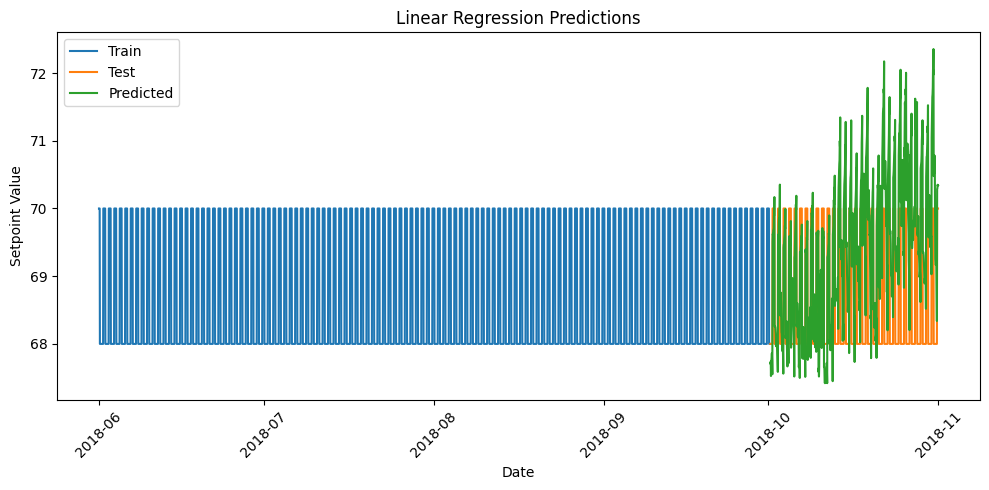

In [100]:
# plot predictions
plt.figure(figsize=(10, 5))
plt.plot(cooling_train.index, cooling_train["setpoint"], label="Train")
plt.plot(cooling_test.index, cooling_test["setpoint"], label="Test")
plt.plot(cooling_test.index, cooling_lr_predictions, label="Predicted")
plt.title("Linear Regression Predictions")
plt.xlabel("Date")
plt.ylabel("Setpoint Value")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [101]:
for param in lr_cooling_model.parameters():
    for num in param:
        try:
            for p in num:
                print(p.item())
        except:
            print(num.item())

0.9694594144821167
-0.01657535322010517
0.0012528563383966684
0.04143008217215538
1.950253963470459


In [102]:
cooling_train.head()

,setpoint,temperature,Direct Normal Radiation [W/m2],temperature_lag_1,consumption_lag_1
timestamp,,,,,
2018-06-01 00:00:00,70.0,66.92,0.0,66.92,0.0
2018-06-01 01:00:00,70.0,66.02,0.0,66.92,0.0
2018-06-01 02:00:00,70.0,66.92,0.0,66.02,0.0
2018-06-01 03:00:00,70.0,66.92,0.0,66.92,0.0
2018-06-01 04:00:00,68.0,66.92,0.0,66.92,0.0


### P-values

In [103]:
# Get predictions on train set
cooling_lr_train_predictions, cooling_lr_train_actuals = evaluate(lr_cooling_model, cooling_lr_dataloader_train)

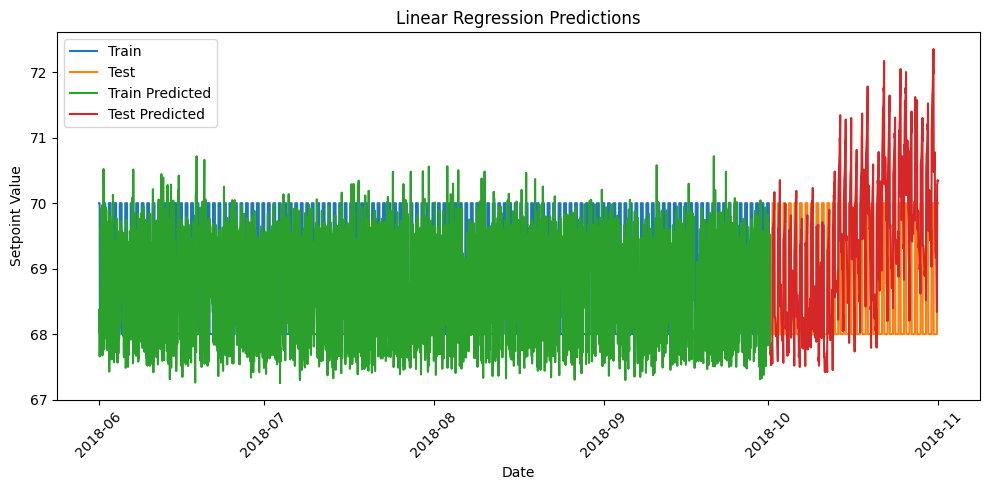

In [104]:
# plot predictions
plt.figure(figsize=(10, 5))
plt.plot(cooling_train.index, cooling_train["setpoint"], label="Train")
plt.plot(cooling_test.index, cooling_test["setpoint"], label="Test")
plt.plot(cooling_train.index, cooling_lr_train_predictions, label="Train Predicted")
plt.plot(cooling_test.index, cooling_lr_predictions, label="Test Predicted")
plt.title("Linear Regression Predictions")
plt.xlabel("Date")
plt.ylabel("Setpoint Value")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [105]:
cooling_p_values = get_pvalues(
    lr_cooling_model, 
    cooling_lr_dataset_train, 
    cooling_lr_train_actuals, 
    cooling_lr_train_predictions
)

In [106]:
for i, col in enumerate(cooling_train.columns):
    print(col + ":")
    print("\t-  ", cooling_p_values[i])

setpoint:
	-   1.911107783136856e-08
temperature:
	-   0.978840649124257
Direct Normal Radiation [W/m2]:
	-   0.8219967862870152
temperature_lag_1:
	-   0.9446348344792628
consumption_lag_1:
	-   0.8843603629189778
